# Multiplicity determination with super-basic Bayesian Statistics

In [1]:
labels = ["nPH", "nPN"]
nmax = 4

In [2]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix,
    plot_confusion_matrix,
)

sys.path.append("..")
from helpers import tridata

Welcome to JupyROOT 6.16/00


In [3]:
class Bayes:
    def __init__(self, train, max_neutrons, label):
        # Hypotheses: Zero to max neutrons
        self._hypos = range(0, max_neutrons + 1)

        # 'Fit' -> Create PDF for all numbers of neutrons
        # TODO: Should they be normalized?
        self._hits = {
            h: np.histogram(train[train[label] == h]["nHits"], range=(0, 500), bins=500, density=True,)[0]
            for h in self._hypos
        }
        self._clus = {
            h: np.histogram(train[train[label] == h]["nClus"], range=(0, 500), bins=500, density=True,)[0]
            for h in self._hypos
        }
        self._edep = {
            h: np.histogram(train[train[label] == h]["Edep"], range=(0, 5000), bins=500, density=True,)[0]
            for h in self._hypos
        }

    def predict(self, x):
        # 'Predict' -> Use PDFs to get probabilities and take the highest
        probs = [
            self._hits[h][x["nHits"]] * self._clus[h][x["nClus"]] * self._edep[h][x["Edep"].floordiv(10).astype(int)]
            for h in self._hypos
        ]
        y_pred = np.argmax(probs, axis=0)
        return y_pred

In [4]:
traindata, testdata = tridata(distance=15, doubleplane=30, energy=600, erel=500, nmax=nmax, physics="inclxx")

## Example Fit / Calibration & Prediction

In [5]:
model = Bayes(traindata, nmax, labels[0])
y_pred = model.predict(testdata)
y_true = testdata[labels[0]].values.ravel()

print(list(zip(y_true, y_pred))[0:50])

[(4, 4), (1, 1), (3, 3), (2, 2), (2, 2), (4, 3), (4, 4), (1, 1), (2, 2), (2, 2), (3, 3), (3, 3), (2, 1), (1, 1), (4, 4), (0, 0), (3, 3), (1, 1), (2, 2), (2, 2), (3, 3), (4, 3), (3, 4), (1, 1), (3, 3), (2, 2), (2, 2), (1, 1), (4, 3), (3, 3), (1, 1), (3, 2), (3, 2), (2, 2), (3, 4), (3, 3), (3, 3), (3, 3), (2, 2), (4, 3), (3, 3), (1, 1), (3, 3), (2, 2), (3, 3), (2, 2), (2, 3), (2, 2), (3, 3), (2, 3)]


In [6]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

bac = balanced_accuracy_score(y_true, y_pred)
print(bac)
cm = confusion_matrix(y_true, y_pred, labels=range(0, nmax + 1))
print(cm)
cmrel = confusion_matrix(y_true, y_pred, labels=range(0, nmax + 1), normalize="true")
print((cmrel * 100).round())

0.7875102766352079
[[ 2067     2     0     1     1]
 [    1 38573  3915    19     7]
 [    1  5897 29324  6972   129]
 [    3   340  7863 23971  8995]
 [    3     7   609  7315 24733]]
[[100.   0.   0.   0.   0.]
 [  0.  91.   9.   0.   0.]
 [  0.  14.  69.  16.   0.]
 [  0.   1.  19.  58.  22.]
 [  0.   0.   2.  22.  76.]]


Text(69.0, 0.5, 'True')

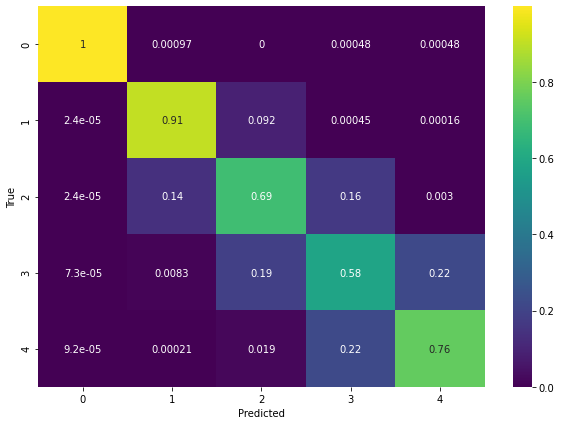

In [7]:
plt.figure(figsize=(10, 7))
ax = sns.heatmap(cmrel, cmap="viridis", annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

## Evaluation for different max multiplicities

In [8]:
for dp in [12, 30]:
    for n in [1, 2, 3, 4, 5]:
        for label in labels:
            traindata, testdata = tridata(distance=15, doubleplane=dp, energy=600, erel=500, nmax=n, physics="inclxx")

            model = Bayes(traindata, n, label)
            y_pred = model.predict(testdata)
            y_true = testdata[label].values.ravel()

            bac = balanced_accuracy_score(y_true, y_pred)
            cm = confusion_matrix(y_true, y_pred, labels=range(0, n + 1))
            print(dp, n, label, bac)
            print(cm)
            print("\n")

12 1 nPH 0.9992920517578248
[[ 9819    10]
 [   12 30101]]


12 1 nPN 0.9998685723673402
[[ 9779     0]
 [    8 30427]]


12 2 nPH 0.8500115273232643
[[11922     7     6]
 [    4 35683  8859]
 [    6  5760 17306]]


12 2 nPN 0.7769259089237827
[[11986     0     0]
 [    3 23020  7171]
 [    4 16330 21509]]


12 3 nPH 0.7441937987465019
[[12507    16     4     0]
 [    0 39853  9978   175]
 [    1  9869 19015 10617]
 [    2   818  4516 12453]]


12 3 nPN 0.6505153602972944
[[12621     0     0     0]
 [    3 23316  6354   876]
 [    2 16145  9583 11610]
 [    7  8602  7913 23022]]


12 4 nPH 0.6677723082339595
[[12780     6     2     0     1]
 [    0 41096 10303   194    16]
 [    0 11628 22599 11421  1486]
 [    1  1594  8745 13752 10617]
 [    3    83  1038  3512  9311]]


12 4 nPN 0.5706283968923043
[[13053     0     0     0     0]
 [    1 23039  6264   759    43]
 [    1 16226  9751  7449  4237]
 [    2  8234  7712  9542 13959]
 [    4  3864  4830  7860 23544]]


12 5 nPH 0.608520945